# Sequence-to-sequence Autoencoder & Auxiliary Tasks
<br>

<font color='#2c3e50'>
<ul>
    
<li>
    
This exercise will demonstrate how to implement a simple `Sequence-to Sequence (Seq2Seq)` autoencoder (AE).</li>
    
<li> 
    
Apart from Seq2Seq AE, we will also see how to `regularise` the training of a model using an `auxiliary` task.</li>    

    
<li> 

Similar to the previous problem, the `main task` is `time-series classification`. However, we will use Seq2Seq AE. As a result, an obvious choice for an `auxiliary task` is `time-series reconstruction`. </li>      
    

<li> 
    
Similar to previous problem, the code is `almost` complete, and you just need to implement a few functions.</li>
    
</ul>
    
</font>

## 1. Tasks:
<br>
<font color='#2c3e50'>
<ul>

<li>
    
Use the RNN unfolding implemented in previous tasks to write/complete ``forward()`` functions for Encoder and Decoder classes.</li>

<li>

Analyse the loss curves and see if you can `spot` regularisation behaviour. </li>  

</font> 

## 2. Hints:
<br>

<font color='#2c3e50'>

Major components of Se2Seq in this case are:    
<ul>
    
<li> <b>Encoder:</b> Its straightforward. Encoder just contains a RNNCell. Unroll it and obtain hidden state after last time-step. (Similar to last exercise)</li>
    
<li> <b>Classifier:</b> Takes the hidden state vector generated by encoder and maps in to 0/1 prediction     

<li> <b>Decoder:</b> It consists of a RNNCell and a linear layer. (discussed below)</li>
      
</ul>    
</font>

### 2.1 Decoder:
<br>
<font color='#2c3e50'>

<ul>
<li> 
        
<b>RNNCell:</b> Intialise the hidden state with the state vector generated by encoder. Here, you need to collect the hidden state vectors after each time-step. Process/transpose these hidden state vectors into shape of `(batch_size,n_steps,hidden_units)`</li>
    

    
<li>
    
<b>Linear Layer:</b> It maps the hidden state vectors into input space i.e. reconstructs the time-series. `(Batch_size,n_steps,hidden_units)` to `(Batch_size,n_steps,input_dims)` </li>
       
</ul>
 
    

<img src="./img/decoder.jpeg" alt="Drawing" style="width: 800px;"/>    

    
<b>Note:</b> Unlike discussion in lecture, we are here trying to reconstruct the time-series from step 1 to n (instead of n to 1). You can reverse the input time-series to do reconstruction in reverse order.     

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
import numpy as np
from utils import get_validation_score_AE
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim,device):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNNCell(input_dim, hidden_dim)
        self.device=device
    
    def forward(self, x):
        hidden = self.init_hidden(x)
        time_steps=x.shape[1]                #shape of x is (batches,time_steps,features)
        
        ######################################
        # write your code here
        for i in range(0,time_steps):
            inputs=x[:,i]                    # (batch,features) shape
            hidden = self.rnn(inputs,hidden)        
                        
        #######################################
        return hidden                        # return hidden states obtained after final time-step
    
    def init_hidden(self, x):
        h0 = torch.zeros(x.size(0), self.hidden_dim)
        return h0.to(self.device)

In [3]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, linear_latent_dim,device):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNNCell(input_dim, hidden_dim)
        self.linear_layers=nn.Sequential(nn.Linear(hidden_dim, linear_latent_dim),nn.Sigmoid(),nn.Linear(linear_latent_dim, input_dim),)
        self.device=device
        
    
    def forward(self, x,states):
        hidden = states
        time_steps=x.shape[1]            #shape of x is (batches,time_Steps,features)
        
        all_hidden=[]
        ###################################
        # write your code here
        for i in range(0,time_steps):
            inputs=x[:,i]                # (batch,features) shape
            hidden = self.rnn(inputs,hidden)
            all_hidden.append(hidden)

        all_hidden=torch.stack(all_hidden)     # (time_steps,batches,hidden_dim)
        
        all_hidden=all_hidden.transpose_(1,0)  #(batches,time_steps,hidden_dim)
        
        out=self.linear_layers(all_hidden)     # (batches,time_steps,hidden_dim)
        #######################################
        return out
    

In [4]:

class RNN_Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, decoder_linear_dim,device):
        super().__init__()
        self.encoder=Encoder(input_dim,hidden_dim,device)        
        self.decoder=Decoder(input_dim,hidden_dim,decoder_linear_dim,device)
        self.fc = nn.Linear(hidden_dim, 1)   # classification layer
        self.activation = nn.Sigmoid()
        self.device=device
    
    def forward(self,x):
        states=self.encoder(x)
        recon=self.decoder(x,states)
        pred=self.fc(states) 
        return recon, self.activation(pred)

In [5]:
def trainer(model,training_set,validation_set,device,lr,store_name,epochs=10):
    ##### Recieve data and labels 
    T,L=training_set 
    Val_T,Val_L=validation_set
    
    ###### intialise optimiser and criterion
    
    optimizer_model = torch.optim.SGD(model.parameters(),lr,momentum=0.9, nesterov=True)
    
    criterion1 = nn.BCELoss().to(device) # classification loss
    criterion2 = nn.MSELoss().to(device) # Reconstruction loss


    best=0
    
    a=0.5 # weightage of loss 1
    
    b=0.5 # weightage of loss 2
    
    LOSS=[]                 # we are only interetsed in analysing BCE loss
    VAL_LOSS=[]
    
    for epoch in range(0,epochs):
        model.train()
        Loss1=0
        Loss2=0
        Total_loss=0
        for k in range(0,len(T)):
            
            inputs=T[k]
            labels=L[k]
            
            inputs=torch.Tensor(inputs).to(device)
            labels=torch.Tensor(labels).type(torch.FloatTensor).to(device)
            
            recon,pred=model(inputs)
            
            loss1=criterion1(pred[:,0],labels)
            loss2=criterion2(recon,inputs)
            
            loss=a*loss1+b*loss2 # a+b=1 # combine both losses
            
            optimizer_model.zero_grad()
            loss.backward()
            optimizer_model.step()
            
            Loss1=Loss1+loss1
            Loss2=Loss2+loss2
            Total_loss=Total_loss+loss
        
        LOSS.append((Loss1/len(T)).detach().cpu().numpy())   
        Val_ROC, val_loss=get_validation_score_AE(model,Val_T,Val_L)
        VAL_LOSS.append(val_loss.detach().cpu().numpy())    
        
        print(' Epoch: {:.1f} MSE_loss {:.4f} BCE_Loss {:.4f} Total_Loss {:.4f} Validation_AUC {:.4f}'.format(epoch,(Loss2/len(T)),(Loss1/len(T)),(Total_loss/len(T)), Val_ROC))
        
        if best<Val_ROC:
           torch.save(model, './'+store_name) 

    return torch.load('./'+store_name).to(device),LOSS,VAL_LOSS     


In [6]:
### load data 
from get_data import get_training_data,get_validation_data
T,L=get_training_data(batch_size=32)                #returns lists of training data and label batches
Val_T,Val_L=get_validation_data()                   # numpy arrays of validation data and labels
print(T[0].shape)                                   # (batch_size,time_steps,n_features)

(33, 48, 59)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
n_features=T[0].shape[2]      # 76 dimensional vector at each time step
recurrent_units=128          # number of recurrent hidden units in encoder and decoder RNN Cells  
latent_linear_units=32       # units in linear layers in Decoder. This layer maps hidden states at each time-step to input space in reconstruction.
lr=0.001

# get model object
model=RNN_Autoencoder(n_features,recurrent_units,latent_linear_units,device)
print(model)


RNN_Autoencoder(
  (encoder): Encoder(
    (rnn): RNNCell(59, 128)
  )
  (decoder): Decoder(
    (rnn): RNNCell(59, 128)
    (linear_layers): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=32, out_features=59, bias=True)
    )
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [9]:
model=model.to(device)
model, training_loss, validation_loss=trainer(model,(T,L),(Val_T,Val_L),device,lr,store_name='lstm',epochs=10)

 Epoch: 0.0 MSE_loss 0.4673 BCE_Loss 0.4919 Total_Loss 0.4796 Validation_AUC 0.6661
 Epoch: 1.0 MSE_loss 0.3956 BCE_Loss 0.4254 Total_Loss 0.4105 Validation_AUC 0.7487
 Epoch: 2.0 MSE_loss 0.3573 BCE_Loss 0.4001 Total_Loss 0.3787 Validation_AUC 0.7855
 Epoch: 3.0 MSE_loss 0.3366 BCE_Loss 0.3715 Total_Loss 0.3540 Validation_AUC 0.8005
 Epoch: 4.0 MSE_loss 0.3255 BCE_Loss 0.3545 Total_Loss 0.3400 Validation_AUC 0.8073
 Epoch: 5.0 MSE_loss 0.3195 BCE_Loss 0.3507 Total_Loss 0.3351 Validation_AUC 0.8100
 Epoch: 6.0 MSE_loss 0.3162 BCE_Loss 0.3491 Total_Loss 0.3326 Validation_AUC 0.8114
 Epoch: 7.0 MSE_loss 0.3144 BCE_Loss 0.3479 Total_Loss 0.3312 Validation_AUC 0.8124
 Epoch: 8.0 MSE_loss 0.3133 BCE_Loss 0.3471 Total_Loss 0.3302 Validation_AUC 0.8130
 Epoch: 9.0 MSE_loss 0.3127 BCE_Loss 0.3464 Total_Loss 0.3295 Validation_AUC 0.8135


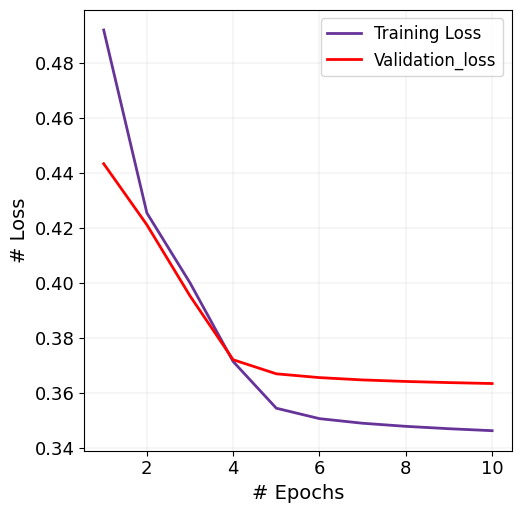

In [10]:
# Plot training and validation loss

fig, ax = plt.subplots(figsize=(5,5))

lw = 2

plt.tight_layout()
ax.plot(np.linspace(1, len(training_loss), num=len(training_loss)),training_loss, color='rebeccapurple',
         lw=2, linestyle='-', label='Training Loss')

ax.plot(np.linspace(1, len(training_loss), num=len(training_loss)),validation_loss, color='r',
         lw=2, linestyle='-', label='Validation_loss')

ax.set_xlabel('# Epochs',fontsize=14)
ax.set_ylabel('# Loss',fontsize=14)
ax.legend(loc="best",fontsize=12)

ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)


plt.grid(color='gray', linestyle='-', linewidth=0.1)


plt.show()